In [1]:
from transmission_line_simulator import *
import transmission_line_simulator
import scipy.constants
import sympy
import scipy.optimize
from scipy.constants import *
import imp
imp.reload(transmission_line_simulator)

<module 'transmission_line_simulator' from 'D:\\Documents-cloud\\qubits\\simulation\\transmission_line_simulator.py'>

# Our Coaxmon design
The coaxmon design has 3 Josephson junctions. A fragment of the design containing the JJs is shown here
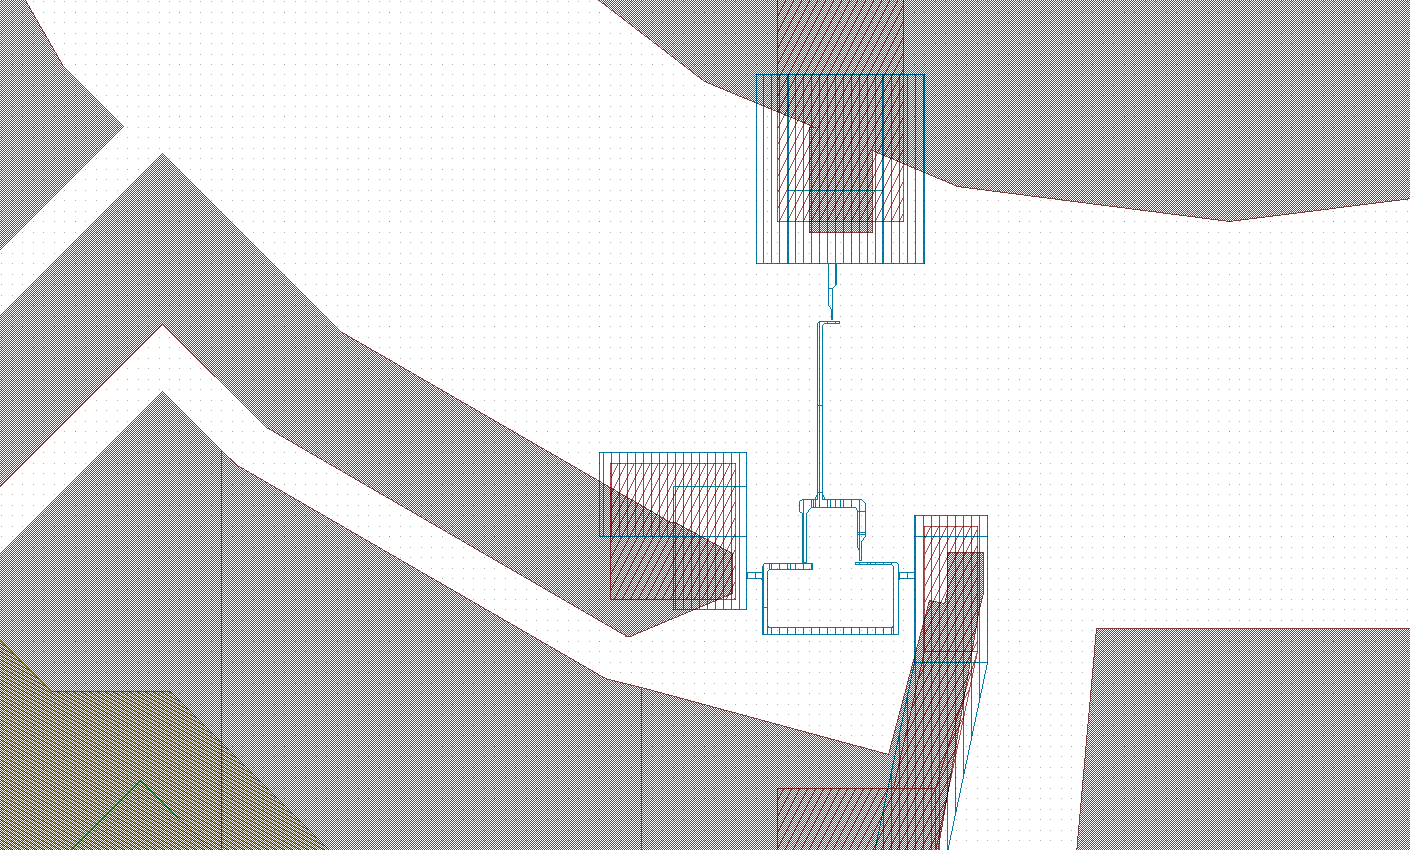

The equivalent circuit model is shown beneath.

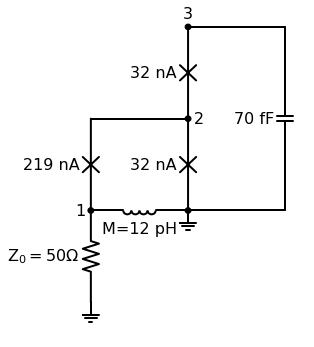

In [2]:
import SchemDraw 
from matplotlib import pyplot as plt
from SchemDraw import elements as el
d = SchemDraw.Drawing()
d.add(el.GND)
d.add(el.DOT)
d.add(el.INDUCTOR, d='left', l=d.unit, label='M=12 pH', lblloc='bot')
d.push()
d.add(el.DOT, d='down', label='1')
d.add(el.RES, label='$Z_0=50\\Omega$', d='down')
d.add(el.GND)
d.pop()
d.add(el.JJ, d='up', label='219 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.DOT, lblloc='rgt', label='2')
d.add(el.JJ, d='down', label='32 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.CAP, d='up', label='70 fF', l=d.unit*2)
d.add(el.LINE, d='left', l=d.unit)
d.add(el.DOT, label='3')
d.add(el.JJ, d='down', label='32 nA')
d.draw()

# code to build the equivalent circuit model

In [3]:
cap = capacitor()
jj1 = inductor()
jj2 = inductor()
jj3 = inductor()
m   = inductor()
#lz  = inductor()


res = resistor()

GND = short()

circuit = transmission_line_system()
circuit.add_element(GND, [0])
circuit.add_element(res, [1, 0])
#circuit.add_element(lz,  [4, 1])
circuit.add_element(m,   [1, 0])
circuit.add_element(jj1, [1, 2])
circuit.add_element(jj2, [0, 2])
circuit.add_element(jj3, [2, 3])
circuit.add_element(cap, [0, 3])

In [4]:
C  = sympy.Symbol('C', real=True, positive=True)
L1 = sympy.Symbol('L1', real=True, positive=True)
L2 = sympy.Symbol('L2', real=True, positive=True)
L3 = sympy.Symbol('L3', real=True, positive=True)
M  = sympy.Symbol('M', real=True, positive=True)
#LZ = sympy.Symbol('Lz', real=True, positive=True)
Z0 = sympy.Symbol('Z0', real=True, positive=True)

omega = sympy.Symbol('\\omega')
domega = sympy.Symbol('\\Delta\\omega')

cap.C = C
jj1.L = L1
jj2.L = L2
jj3.L = L3
m.L = M
#lz.L = LZ
res.R = Z0

In [5]:
boundary_problem = sympy.nsimplify(sympy.Matrix(circuit.create_boundary_problem_matrix(sympy.Symbol('\\omega'))))
#boundary_problem

In [6]:
num_iterations = boundary_problem.shape[0]
for iteration_id in range(num_iterations):
    boundary_problem = sympy.Matrix(boundary_problem)
    num_rows = boundary_problem.shape[0]
    for row_id in range(num_rows):
        row = [i for i in boundary_problem.row(row_id)]
        nonzero_elements = [el_id for el_id, el in enumerate(row) if el != 0]
        if len(nonzero_elements) == 1:
            boundary_problem.col_del(nonzero_elements[0])
            boundary_problem.row_del(row_id)
            break
        if len(nonzero_elements) == 2:
            #print (nonzero_elements)
            if row[nonzero_elements[0]] == -row[nonzero_elements[1]]:
                boundary_problem[:, nonzero_elements[0]] += boundary_problem[:, nonzero_elements[1]]
                boundary_problem.col_del(nonzero_elements[1])
                boundary_problem.row_del(row_id)
                break
            if row[nonzero_elements[0]] == row[nonzero_elements[1]]:
                boundary_problem[:, nonzero_elements[0]] -= boundary_problem[:, nonzero_elements[1]]
                boundary_problem.col_del(nonzero_elements[1])
                boundary_problem.row_del(row_id)
                break
boundary_problem = boundary_problem.T
for iteration_id in range(num_iterations):
    boundary_problem = sympy.Matrix(boundary_problem)
    num_rows = boundary_problem.shape[0]
    for row_id in range(num_rows):
        row = [i for i in boundary_problem.row(row_id)]
        nonzero_elements = [el_id for el_id, el in enumerate(row) if el != 0]
        if len(nonzero_elements) == 1:
            boundary_problem.col_del(nonzero_elements[0])
            boundary_problem.row_del(row_id)
            break
        if len(nonzero_elements) == 2:
            #print (nonzero_elements)
            if row[nonzero_elements[0]] == -row[nonzero_elements[1]]:
                boundary_problem[:, nonzero_elements[0]] += boundary_problem[:, nonzero_elements[1]]
                boundary_problem.col_del(nonzero_elements[1])
                boundary_problem.row_del(row_id)
                break
            if row[nonzero_elements[0]] == row[nonzero_elements[1]]:
                boundary_problem[:, nonzero_elements[0]] -= boundary_problem[:, nonzero_elements[1]]
                boundary_problem.col_del(nonzero_elements[1])
                boundary_problem.row_del(row_id)
                break
boundary_problem = boundary_problem.T
#boundary_problem

**Roots of this polynomial yield the oscillation frequecies and decay rates of the system's modes.**

In [7]:
precise = sympy.expand(boundary_problem.det(method='berkowitz'))
precise

C*L1*L2*M*\omega**4 - I*C*L1*L2*Z0*\omega**3 - C*L1*L3*M*\omega**4 + I*C*L1*L3*Z0*\omega**3 - C*L2*L3*M*\omega**4 + I*C*L2*L3*Z0*\omega**3 - I*C*L2*M*Z0*\omega**3 + I*C*L3*M*Z0*\omega**3 + L1*M*\omega**2 - I*L1*Z0*\omega + L2*M*\omega**2 - I*L2*Z0*\omega - I*M*Z0*\omega

Roots of 4-th order polynomials can be found using numerical methods

# numerical solution

In [8]:
Ic_big = 0.45*0.486*1e-6
Ic_small = 0.2*0.16*1e-6

L1_ = 2e-15/(2*pi*Ic_big)
L2_ = 2e-15/(2*pi*Ic_small)
L3_ = 2e-15/(2*pi*Ic_small)
L1_,L2_,L3_

(1.4554635856597657e-09, 9.94718394324346e-09, 9.94718394324346e-09)

In [9]:
from sympy.polys.rootoftools import rootof
from sympy.polys.polytools import degree, nroots
def find_decay(current):
    M_ = h/(2*e*current)*1e9#h/(2*e*2*np.pi*np.sqrt(25e-12*1e9 - current**2))*3
    typical_parameters[M] = M_
    #print (precise.xreplace(typical_parameters).evalf())
    roots = [float(sympy.re(r.evalf()))+1j*float(sympy.im(r.evalf()))
                 for r in nroots(precise.xreplace(typical_parameters).evalf())]
    real_root = np.imag(roots[np.argmax(roots)])
    return M_, real_root

In [10]:
f_min = 1/(2*np.pi*np.sqrt((1/np.abs(1/typical_parameters[L1]-1/typical_parameters[L2])+typical_parameters[L3])*typical_parameters[C]))
f_max = 1/(2*np.pi*np.sqrt((1/np.abs(1/typical_parameters[L1]+1/typical_parameters[L2])+typical_parameters[L3])*typical_parameters[C]))
f_min/1e9, f_max/1e9

NameError: name 'typical_parameters' is not defined

# Big junction on the left, small junction on the right

In [ ]:
import SchemDraw 
from matplotlib import pyplot as plt
from SchemDraw import elements as el
d = SchemDraw.Drawing()
d.add(el.GND)
d.add(el.DOT)
d.add(el.INDUCTOR, d='left', l=d.unit, label='M=12 pH', lblloc='bot')
#d.add(el.JJ, d='left', l=d.unit*0.25)
#d.add(el.JJ, d='left', l=d.unit*0.25, label='4 μA')
#d.add(el.JJ, d='left', l=d.unit*0.25)
d.push()
d.add(el.RES, label='$Z_0=50\\Omega$', d='down')
d.add(el.DOT)
d.add(el.GND)
d.pop()
d.add(el.JJ, d='up', label='219 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.JJ, d='down', label='32 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.CAP, d='up', label='70 fF', l=d.unit*2)
d.add(el.LINE, d='left', l=d.unit)
d.add(el.JJ, d='down', label='32 nA')
d.draw()
plt.savefig('coil_schematic_transmon_simple_inverted.svg')
plt.savefig('coil_schematic_transmon_simple_inverted.png')

typical_parameters = {C:70e-15*1e9, L1: L1_*1e9, 
                      L2:L2_*1e9, L3: L3_*1e9, M: 12e-3, Z0:50, LZ:0e-6}#3000e-9}
current_periods = np.logspace(-6, -3)
decays = []
inductances = []
for current_period in current_periods:
    inductance, decay = find_decay(current_period)
    inductances.append(np.abs(inductance))
    decays.append(np.abs(1/decay))
    
#%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.loglog(current_periods*1e3, np.asarray(decays)*1e-3/2)
plt.xlabel('Current per flux period, [mA/$\Phi_0]$')
plt.ylabel('$T_1$, μs')
plt.grid(True)
plt.tight_layout()
plt.savefig('decay_fast.svg')
plt.savefig('decay_fast.png')

# Big junction on the right, small junction on the left

In [ ]:
import SchemDraw 
from matplotlib import pyplot as plt
from SchemDraw import elements as el
d = SchemDraw.Drawing()
d.add(el.GND)
d.add(el.DOT)
d.add(el.INDUCTOR, d='left', l=d.unit, label='M=12 pH', lblloc='bot')
#d.add(el.JJ, d='left', l=d.unit*0.25)
#d.add(el.JJ, d='left', l=d.unit*0.25, label='4 μA')
#d.add(el.JJ, d='left', l=d.unit*0.25)
d.push()
d.add(el.RES, label='$Z_0=50\\Omega$', d='down')
d.add(el.DOT)
d.add(el.GND)
d.pop()
d.add(el.JJ, d='up', label='32 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.JJ, d='down', label='219 nA')
d.add(el.LINE, d='right', l=d.unit)
d.add(el.CAP, d='up', label='70 fF', l=d.unit*2)
d.add(el.LINE, d='left', l=d.unit)
d.add(el.JJ, d='down', label='32 nA')
d.draw()
plt.savefig('coil_schematic_transmon_simple_correct.svg')
plt.savefig('coil_schematic_transmon_simple_correct.png')

typical_parameters = {C:70e-15*1e9, L1: L2_*1e9, 
                      L2:L1_*1e9, L3: L3_*1e9, M: 12e-3, Z0:50, LZ:0e-6}#3000e-9}
current_periods = np.logspace(-6, -3)
decays = []
inductances = []

for current_period in current_periods:
    inductance, decay = find_decay(current_period)
    inductances.append(np.abs(inductance))
    decays.append(np.abs(1/decay))
    
#%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.loglog(current_periods*1e3, np.asarray(decays)*1e-3/2)
plt.xlabel('Current per flux period, [mA/$\Phi_0]$')
plt.ylabel('$T_1$, μs')
plt.grid(True)
plt.tight_layout()
plt.savefig('decay_fast.svg')
plt.savefig('decay_fast.png')